# Clauset-Newman-Moore Greedy Algorithm Tutorial

This tutorial explains the Clauset-Newman-Moore greedy algorithm for community detection and demonstrates its implementation using NetworkX.

In [1]:
# Import required libraries
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import time
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.cluster import hierarchy

## Algorithm Explanation

The Clauset-Newman-Moore algorithm is a hierarchical agglomerative approach to community detection that optimizes modularity. Unlike other algorithms that work by divisive methods (removing edges), this is a "bottom-up" algorithm that merges communities.

### Key Steps:

1. **Initialization**
   - Each node starts as its own community (N communities total)
   - Calculate initial modularity contribution for each pair of connected communities

2. **Greedy Optimization**
   - At each step, merge the pair of communities that results in the maximum increase (or minimum decrease) in modularity
   - The change in modularity when merging communities i and j is given by:
     $$\Delta Q = \frac{e_{ij}}{L} - \frac{k_i k_j}{2L^2}$$
     where:
     - $e_{ij}$ is the number of edges between communities i and j
     - $k_i$ and $k_j$ are the total degrees of communities i and j
     - $L$ is the total number of edges in the network

3. **Efficiency Improvements**
   - The algorithm uses specialized data structures (max heaps and balanced binary trees) to efficiently track and update modularity changes
   - This allows for a time complexity of O(N log²N) for sparse networks, significantly faster than the original O(N³) Newman algorithm
   - The key innovation is using a sparse matrix representation and efficient updates to avoid recalculating all community pairs

4. **Hierarchical Structure**
   - The algorithm naturally produces a dendrogram showing the hierarchical structure of communities
   - The best partition is selected by finding the maximum modularity across all merging steps

## Implementation from Scratch

Let's implement a simplified version of the algorithm to better understand its mechanics. Note that this won't be as efficient as NetworkX's implementation, but it will demonstrate the core concepts.

In [2]:
def simple_cnm(G):
    """
    Simple implementation of Clauset-Newman-Moore algorithm
    
    Parameters:
    -----------
    G : networkx.Graph
        The input graph
        
    Returns:
    --------
    list
        A list of sets, each containing the nodes in one community
    float
        The modularity of the final partition
    list
        History of modularity values
    """
    # Initialize: each node is its own community
    communities = [{node} for node in G.nodes()]
    
    # Total edges (m)
    m = G.number_of_edges()
    
    # Calculate degrees
    degrees = dict(G.degree())
    
    # Initialize community degrees (k_i values)
    community_degrees = {i: sum(degrees[node] for node in comm) 
                         for i, comm in enumerate(communities)}
    
    # Initialize community edges (e_ij values)
    community_edges = {}
    for i, comm_i in enumerate(communities):
        for node_i in comm_i:
            for neighbor in G.neighbors(node_i):
                j = next(idx for idx, comm in enumerate(communities) if neighbor in comm)
                if i != j:
                    community_edges[(i, j)] = community_edges.get((i, j), 0) + 0.5
                    community_edges[(j, i)] = community_edges.get((j, i), 0) + 0.5
    
    # Track modularity history
    modularity_history = [nx.community.modularity(G, communities)]
    
    # Main algorithm loop
    while len(communities) > 1:
        best_delta_q = -float('inf')
        best_merge = None
        
        # Find the best pair to merge
        for i in range(len(communities)):
            for j in range(i+1, len(communities)):
                # Get edge weight between communities (0 if not connected)
                e_ij = community_edges.get((i, j), 0)
                
                # Calculate modularity change
                delta_q = (e_ij / m) - ((community_degrees[i] * community_degrees[j]) / (2 * m * m))
                
                if delta_q > best_delta_q:
                    best_delta_q = delta_q
                    best_merge = (i, j)
        
        # If no improvement is possible, break
        if best_merge is None:
            break
        
        # Get indices to merge
        i, j = best_merge
        
        # Update community edges before merging
        new_community_edges = {}
        for (a, b), w in community_edges.items():
            # Skip edges internal to community j (they'll become internal to i)
            if a == j and b == j:
                continue
                
            # Handle edges from j to other communities
            if a == j:
                new_key = (i, b)
            elif b == j:
                new_key = (a, i)
            else:
                # Adjust indices for communities above j
                new_a = a if a < j else a - 1
                new_b = b if b < j else b - 1
                new_key = (new_a, new_b)
            
            # Add to the new edge dict, combining weights as needed
            new_community_edges[new_key] = new_community_edges.get(new_key, 0) + w
        
        # Merge communities
        communities[i] = communities[i].union(communities[j])
        communities.pop(j)
        
        # Update community degrees
        community_degrees[i] += community_degrees[j]
        # Shift remaining indices down
        for k in range(j+1, len(communities)+1):
            if k in community_degrees:
                community_degrees[k-1] = community_degrees.pop(k)
                
        # Update community edges
        community_edges = new_community_edges
        
        # Calculate current modularity
        current_modularity = nx.community.modularity(G, communities)
        modularity_history.append(current_modularity)
    
    # Final modularity
    final_modularity = modularity_history[-1]
    
    return communities, final_modularity, modularity_history

## Using NetworkX's Implementation

While our simplified implementation helps understand the algorithm, NetworkX provides a highly optimized version that we'll use for practical applications. The NetworkX implementation leverages efficient data structures for significant performance improvements.

In [3]:
# Load the Zachary karate club network
karate = nx.karate_club_graph()

# Get ground truth communities
ground_truth = {}
for node in karate.nodes():
    ground_truth[node] = 0 if karate.nodes[node]['club'] == 'Mr. Hi' else 1

In [4]:
# Apply the Clauset-Newman-Moore algorithm
start_time = time.time()
communities = list(nx.community.greedy_modularity_communities(karate))
end_time = time.time()

# Print execution time
print(f"Time taken: {end_time - start_time:.4f} seconds")

# Print the number of communities found
print(f"Number of communities detected: {len(communities)}")

# Print the communities
for i, community in enumerate(communities):
    print(f"Community {i+1}: {sorted(list(community))}")

Time taken: 0.0016 seconds
Number of communities detected: 3
Community 1: [8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community 2: [1, 2, 3, 7, 9, 12, 13, 17, 21]
Community 3: [0, 4, 5, 6, 10, 11, 16, 19]


In [5]:
# Calculate modularity
modularity = nx.community.modularity(karate, communities)
print(f"Modularity: {modularity:.4f}")

# Convert to a node-to-community mapping for visualization
partition = {}
for i, community in enumerate(communities):
    for node in community:
        partition[node] = i

Modularity: 0.4110


## Visualizing the Results

Let's visualize the communities detected by the algorithm in the Zachary Karate Club network.

In [6]:
# First, create a consistent layout for all visualizations
pos = nx.spring_layout(karate, seed=42)

# Prepare data for visualization
# Use Pastel1 color palette for consistent styling
colors = plt.cm.Pastel1(np.arange(len(communities)))

# Separate edges into within-community and between-community
within_edges = []
between_edges = []
for u, v in karate.edges():
    if partition[u] == partition[v]:
        within_edges.append((u, v))
    else:
        between_edges.append((u, v))

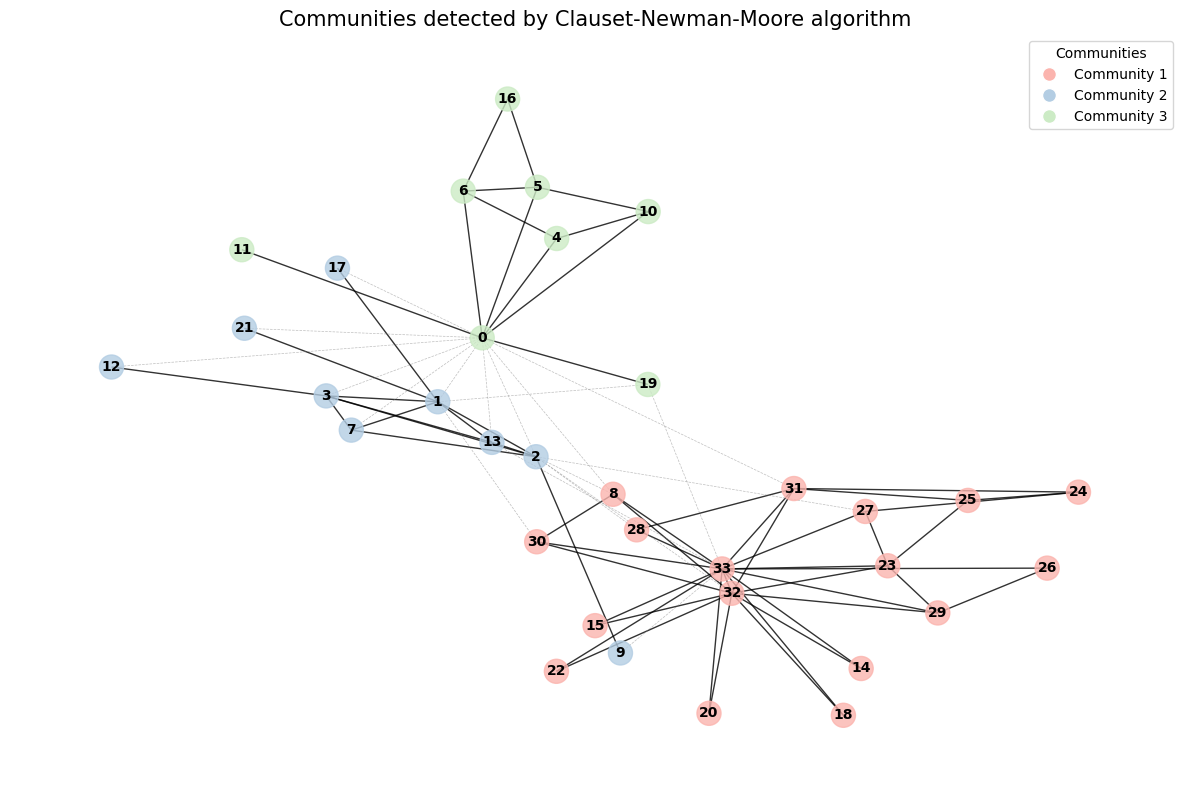

In [7]:
# Create the visualization
plt.figure(figsize=(12, 8))

# Draw nodes with community colors
for i, comm in enumerate(communities):
    nx.draw_networkx_nodes(karate, pos, nodelist=list(comm), 
                           node_color=[colors[i]] * len(comm), 
                           node_size=300, alpha=0.8)

# Draw edges with different styles for within/between communities
nx.draw_networkx_edges(karate, pos, edgelist=within_edges, alpha=0.8, width=1.0)
nx.draw_networkx_edges(karate, pos, edgelist=between_edges, alpha=0.5, width=0.5, 
                       style='dashed', edge_color='gray')

# Draw labels
nx.draw_networkx_labels(karate, pos, font_size=10, font_weight='bold')

# Add a legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=colors[i], markersize=10, 
                          label=f'Community {i+1}')
               for i in range(len(communities))]
plt.legend(handles=legend_patches, loc='upper right', title="Communities")

plt.title("Communities detected by Clauset-Newman-Moore algorithm", size=15)
plt.axis('off')
plt.tight_layout()
plt.show()

## Comparing with Ground Truth

Let's compare the algorithm's results with the known ground truth communities in the Zachary Karate Club network.

In [8]:
# Prepare data for ground truth visualization
pastel_colors = plt.cm.Pastel1(np.arange(2))  # 2 ground truth communities

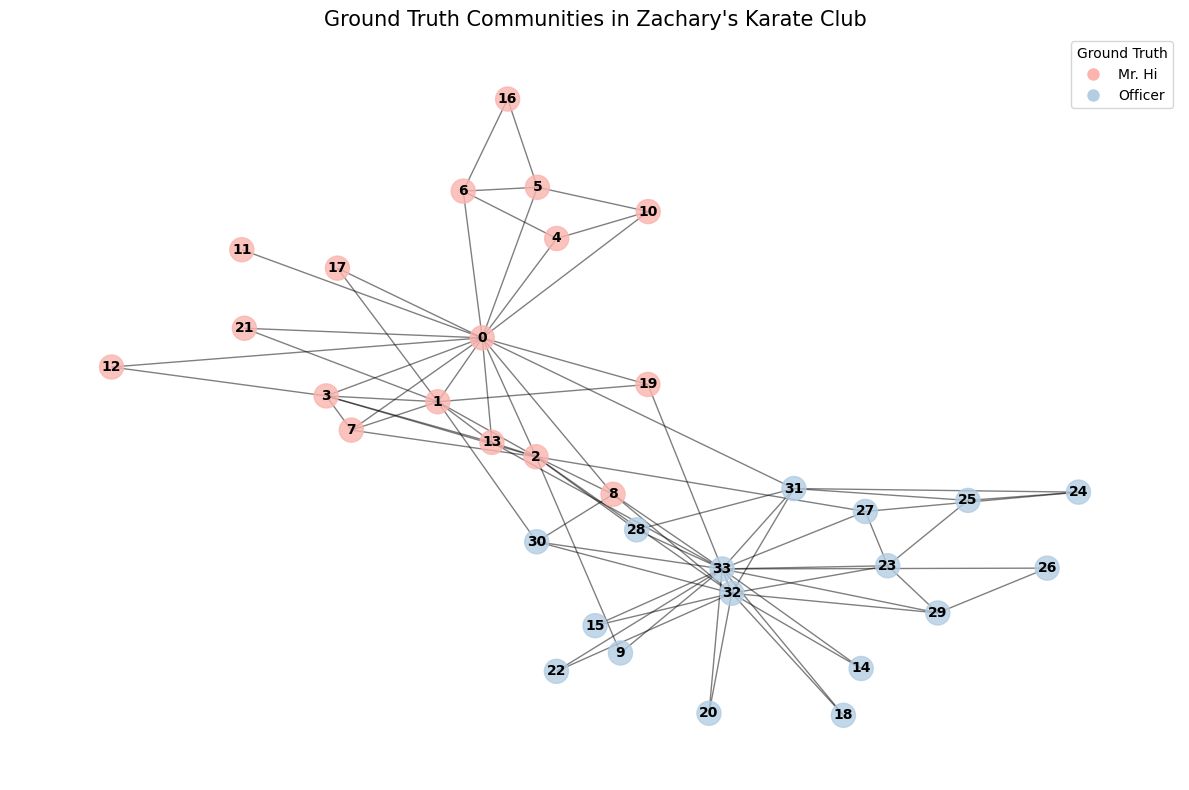

In [9]:
# Create the ground truth visualization
plt.figure(figsize=(12, 8))

# Draw nodes with ground truth colors
for club_id in set(ground_truth.values()):
    club_nodes = [node for node, club in ground_truth.items() if club == club_id]
    nx.draw_networkx_nodes(karate, pos, nodelist=club_nodes, 
                           node_color=[pastel_colors[club_id]] * len(club_nodes), 
                           node_size=300, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(karate, pos, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(karate, pos, font_size=10, font_weight='bold')

# Add legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=pastel_colors[i], markersize=10, 
                             label=f"{'Mr. Hi' if i==0 else 'Officer'}")
                  for i in range(2)]
plt.legend(handles=legend_handles, loc='upper right', title="Ground Truth")

plt.title("Ground Truth Communities in Zachary's Karate Club", size=15)
plt.axis('off')
plt.tight_layout()
plt.show()

## Analyzing Agreement with Ground Truth

Let's quantify how well the algorithm's communities match the ground truth using metrics like Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI):

- **Adjusted Rand Index (ARI)**: Measures the similarity between two clusterings, adjusted for chance. Values range from -1 to 1, where 1 indicates perfect agreement.
  
- **Normalized Mutual Information (NMI)**: Measures the mutual information between the two clusterings, normalized to a 0-1 scale, where 1 indicates perfect agreement.

In [10]:
# Prepare data for evaluating community detection results
nodes = list(karate.nodes())
ground_truth_labels = [ground_truth[node] for node in nodes]
predicted_labels = [partition[node] for node in nodes]

# Calculate evaluation metrics
ari = adjusted_rand_score(ground_truth_labels, predicted_labels)
nmi = normalized_mutual_info_score(ground_truth_labels, predicted_labels)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")

Adjusted Rand Index: 0.5684
Normalized Mutual Information: 0.5646


In [11]:
# Create a summary dataframe and interpret results
summary = pd.DataFrame({
    'Metric': ['Number of communities', 'Modularity', 'Adjusted Rand Index', 'Normalized Mutual Information'],
    'Value': [len(communities), modularity, ari, nmi]
})

# Interpret the results based on metric values
interpretation = ""
if ari > 0.7:
    interpretation += "Strong agreement with ground truth (ARI > 0.7)\n"
elif ari > 0.3:
    interpretation += "Moderate agreement with ground truth (0.3 < ARI < 0.7)\n"
else:
    interpretation += "Weak agreement with ground truth (ARI < 0.3)\n"

if nmi > 0.7:
    interpretation += "High shared information with ground truth (NMI > 0.7)"
elif nmi > 0.3:
    interpretation += "Moderate shared information with ground truth (0.3 < NMI < 0.7)"
else:
    interpretation += "Low shared information with ground truth (NMI < 0.3)"

print("\nInterpretation:")
print(interpretation)

# Display summary table
display(summary)


Interpretation:
Moderate agreement with ground truth (0.3 < ARI < 0.7)
Moderate shared information with ground truth (0.3 < NMI < 0.7)


,Metric,Value
0,Number of communities,3.000000
1,Modularity,0.410965
2,Adjusted Rand Index,0.568439
3,Normalized Mutual Information,0.564607


## Hierarchical Structure Visualization

The Clauset-Newman-Moore algorithm builds communities hierarchically by merging pairs of communities at each step. Let's visualize this hierarchical structure using a dendrogram, which shows the sequence of community merges.

In [12]:
# Create a smaller version of the karate club network for clearer visualization
small_karate = nx.Graph()
for u, v in list(karate.edges())[:30]:  # Use first 30 edges
    if u < 20 and v < 20:  # Include only nodes 0-19
        small_karate.add_edge(u, v)

In [13]:
# Function to track communities as they merge
def track_community_merges(G):
    """
    Track the merging of communities in the CNM algorithm
    
    Returns:
    --------
    Z : array
        Hierarchical clustering linkage matrix for dendrogram
    modularity_gains : list
        Modularity gain at each merge step
    """
    n = G.number_of_nodes()
    nodes = list(sorted(G.nodes()))
    
    # Start with each node in its own community
    communities = [{node} for node in nodes]
    
    # Keep track of merge history in scipy linkage format
    merge_history = []
    modularity_gains = []
    
    # Keep track of current cluster id (will start at n for merged clusters)
    next_id = n
    
    # Map nodes to their current cluster ids
    node_to_cluster = {node: i for i, node in enumerate(nodes)}
    cluster_sizes = {i: 1 for i in range(n)}
    
    # Calculate edge weights and node degrees
    m = G.number_of_edges()
    degrees = dict(G.degree())
    
    # Main loop - simulate CNM algorithm
    while len(communities) > 1:
        best_delta_q = -float('inf')
        best_merge = None
        
        # Try all possible merges
        for i in range(len(communities)):
            for j in range(i+1, len(communities)):
                # Calculate modularity change if we merge i and j
                comm_i = communities[i]
                comm_j = communities[j]
                
                # Count edges between communities
                e_ij = sum(1 for u in comm_i for v in comm_j if G.has_edge(u, v))
                
                # Calculate degrees of communities
                k_i = sum(degrees[node] for node in comm_i)
                k_j = sum(degrees[node] for node in comm_j)
                
                # Change in modularity
                delta_q = e_ij/m - (k_i * k_j)/(2*m*m)
                
                if delta_q > best_delta_q:
                    best_delta_q = delta_q
                    best_merge = (i, j, delta_q)
        
        if best_merge is None:
            break
            
        # Perform the best merge
        i, j, delta_q = best_merge
        modularity_gains.append(delta_q)
        
        # Record the merge (convert to current cluster ids)
        cluster_i = min(node_to_cluster[next(iter(communities[i]))], 
                        node_to_cluster[next(iter(communities[j]))])
        cluster_j = max(node_to_cluster[next(iter(communities[i]))], 
                        node_to_cluster[next(iter(communities[j]))])
        
        # Convert modularity gain to distance (higher gain = smaller distance)
        # Add a small constant to ensure positive distances
        distance = 1.0 - delta_q + 0.1  
        
        merge_history.append([
            cluster_i, cluster_j, 
            distance, 
            cluster_sizes[cluster_i] + cluster_sizes[cluster_j]
        ])
        
        # Update cluster mapping for all nodes in community j
        for node in communities[j]:
            node_to_cluster[node] = next_id
            
        # Update cluster mapping for all nodes in community i
        for node in communities[i]:
            node_to_cluster[node] = next_id
        
        # Update cluster size
        cluster_sizes[next_id] = cluster_sizes.get(cluster_i, 0) + cluster_sizes.get(cluster_j, 0)
        next_id += 1
        
        # Merge the communities
        communities[i] = communities[i].union(communities[j])
        communities.pop(j)
    
    # Convert merge history to scipy linkage format
    Z = np.array(merge_history)
    return Z, modularity_gains

In [14]:
# Apply the tracking function to our small network
Z, modularity_gains = track_community_merges(small_karate)

# Display the shape of the linkage matrix and modularity gain summary
print(f"Linkage matrix shape: {Z.shape}")
print(f"Number of merge steps: {len(modularity_gains)}")
print(f"Total modularity gain: {sum(modularity_gains):.4f}")
print(f"Max modularity gain in a single step: {max(modularity_gains):.4f}")

Linkage matrix shape: (15, 4)
Number of merge steps: 15
Total modularity gain: 0.1360
Max modularity gain in a single step: 0.0344


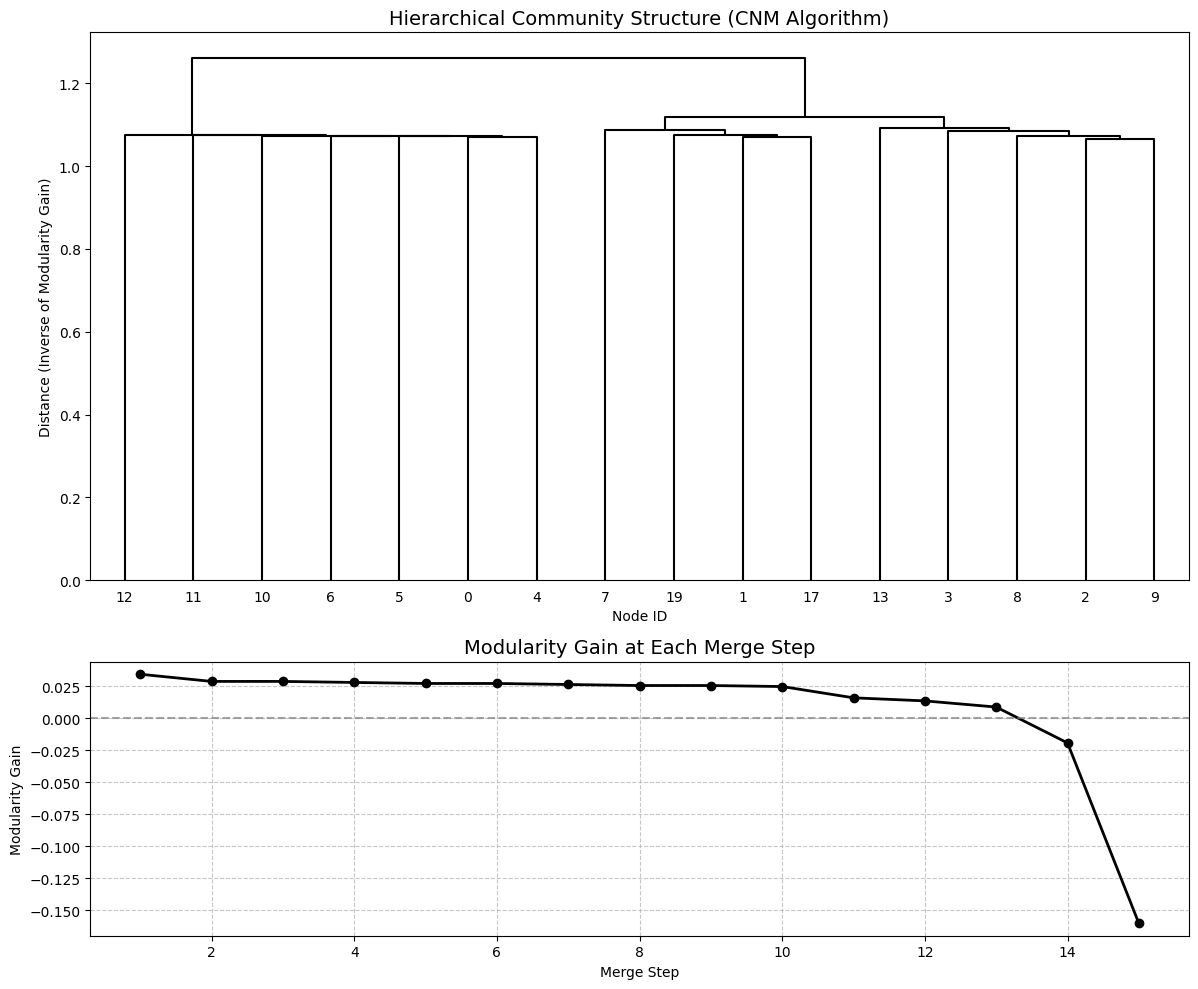

In [15]:
# Create a figure with two subplots: dendrogram and modularity gains
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# Plot dendrogram with black color for a cleaner look
labels = [str(node) for node in sorted(small_karate.nodes())]
dendrogram = hierarchy.dendrogram(
    Z,
    labels=labels,
    orientation='top',
    leaf_font_size=10,
    color_threshold=None,  # Use None to make all links black
    ax=ax1,
    above_threshold_color='black'
)
ax1.set_title("Hierarchical Community Structure (CNM Algorithm)", fontsize=14)
ax1.set_xlabel("Node ID")
ax1.set_ylabel("Distance (Inverse of Modularity Gain)")

# Plot modularity gains with black color for consistency
steps = range(1, len(modularity_gains) + 1)
ax2.plot(steps, modularity_gains, 'o-', linewidth=2, color='black')
ax2.set_xlabel("Merge Step")
ax2.set_ylabel("Modularity Gain")
ax2.set_title("Modularity Gain at Each Merge Step", fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at y=0 to show positive vs negative gains
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [16]:
# Get the final communities from NetworkX implementation for comparison
final_communities = list(nx.community.greedy_modularity_communities(small_karate))

# Display the final communities
print("Final communities detected by CNM algorithm:")
for i, community in enumerate(final_communities):
    print(f"Community {i+1}: {sorted(community)}")

# Calculate modularity of the final partition
final_modularity = nx.community.modularity(small_karate, final_communities)
print(f"\nFinal modularity score: {final_modularity:.4f}")

Final communities detected by CNM algorithm:
Community 1: [0, 4, 5, 6, 10, 11, 12]
Community 2: [2, 3, 8, 9, 13]
Community 3: [1, 7, 17, 19]

Final modularity score: 0.1792


### Interpretation of the Hierarchical Structure

The dendrogram above shows:

1. **Merge sequence**: Each vertical line represents a merge between communities. The height of the line corresponds to the "distance" (inverse of modularity gain).

2. **Early merges**: The lower merges (shorter lines) represent communities that were merged early with high modularity gain.

3. **Late merges**: Taller lines represent merges that happened later with smaller gains or even modularity decrease.

The modularity gain plot shows:
- How each merge affects the overall network modularity
- Positive values indicate beneficial merges
- Negative values (if any) indicate forced merges that decrease modularity

## Modularity Optimization Process

Let's examine how the overall modularity changes throughout the community merging process. This will help us understand how the algorithm finds the optimal partition by tracking the modularity score at each step.

In [17]:
# Use a more efficient implementation to track modularity changes
def track_modularity_changes(G):
    """
    Track modularity changes at each step of the algorithm
    
    Returns:
    --------
    modularity_scores : list
        Modularity after each merge
    merge_steps : list
        Description of each merge step
    best_communities : list
        The communities at maximum modularity
    best_step : int
        The step where modularity was maximized
    """
    # Start with each node in its own community
    communities = [{node} for node in G.nodes()]
    community_map = {i: i for i in range(len(communities))}  # Track merged communities
    
    # Calculate initial modularity
    modularity_scores = [nx.community.modularity(G, communities)]
    merge_steps = []
    
    # Total edges and degrees
    m = G.number_of_edges()
    degrees = dict(G.degree())
    
    # Community degrees
    community_degrees = {i: sum(degrees[node] for node in comm) 
                         for i, comm in enumerate(communities)}
    
    # Track best partition
    best_modularity = modularity_scores[0]
    best_communities = [comm.copy() for comm in communities]
    best_step = 0
    
    while len(communities) > 1:
        best_delta_q = -float('inf')
        best_merge = None
        
        # Try all possible merges
        for i in range(len(communities)):
            for j in range(i+1, len(communities)):
                # Count edges between communities
                e_ij = sum(1 for u in communities[i] for v in communities[j] if G.has_edge(u, v))
                
                # Calculate modularity change
                delta_q = e_ij/m - (community_degrees[i] * community_degrees[j])/(2*m*m)
                
                if delta_q > best_delta_q:
                    best_delta_q = delta_q
                    best_merge = (i, j, delta_q)
        
        # If no improvement is possible, break
        if best_merge is None:
            break
        
        # Apply the best merge
        i, j, delta_q = best_merge
        
        # Record the merge
        merge_steps.append(f"Merge communities {community_map[i]} and {community_map[j]}, ΔQ = {delta_q:.4f}")
        
        # Update community degrees
        community_degrees[i] += community_degrees[j]
        
        # Merge communities
        communities[i] = communities[i].union(communities[j])
        communities.pop(j)
        
        # Update community map
        community_map[i] = len(modularity_scores)  # Assign new merged ID
        # Adjust indices for communities after j
        for k in range(j+1, len(communities)+1):
            if k in community_map:
                community_map[k-1] = community_map.pop(k)
        
        # Update community degrees indices
        for k in range(j+1, len(communities)+1):
            if k in community_degrees:
                community_degrees[k-1] = community_degrees.pop(k)
        
        # Calculate new modularity
        new_modularity = modularity_scores[-1] + delta_q
        modularity_scores.append(new_modularity)
        
        # Check if this is the best partition
        if new_modularity > best_modularity:
            best_modularity = new_modularity
            best_communities = [comm.copy() for comm in communities]
            best_step = len(modularity_scores) - 1
    
    return modularity_scores, merge_steps, best_communities, best_step

In [18]:
# Apply the tracking function to our small karate network
modularity_scores, merge_steps, best_communities, best_step = track_modularity_changes(small_karate)

# Print some basic statistics
print(f"Starting with {len(small_karate.nodes())} communities (1 node per community)")
print(f"Optimal number of communities: {len(best_communities)}")
print(f"Maximum modularity: {modularity_scores[best_step]:.4f} at step {best_step}")

# Print a sample of the merge steps for insight
print("\nSample of merge steps:")
for i, step in enumerate(merge_steps[:5]):
    print(f"Step {i+1}: {step}")
print("...")
for i, step in enumerate(merge_steps[-3:]):
    print(f"Step {len(merge_steps)-2+i}: {step}")

Starting with 16 communities (1 node per community)
Optimal number of communities: 3
Maximum modularity: 0.1792 at step 13

Sample of merge steps:
Step 1: Merge communities 2 and 15, ΔQ = 0.0344
Step 2: Merge communities 0 and 4, ΔQ = 0.0288
Step 3: Merge communities 1 and 13, ΔQ = 0.0288
Step 4: Merge communities 2 and 5, ΔQ = 0.0280
Step 5: Merge communities 4 and 6, ΔQ = 0.0272
...
Step 13: Merge communities 11 and 12, ΔQ = 0.0088
Step 14: Merge communities 12 and 13, ΔQ = -0.0192
Step 15: Merge communities 10 and 14, ΔQ = -0.1600


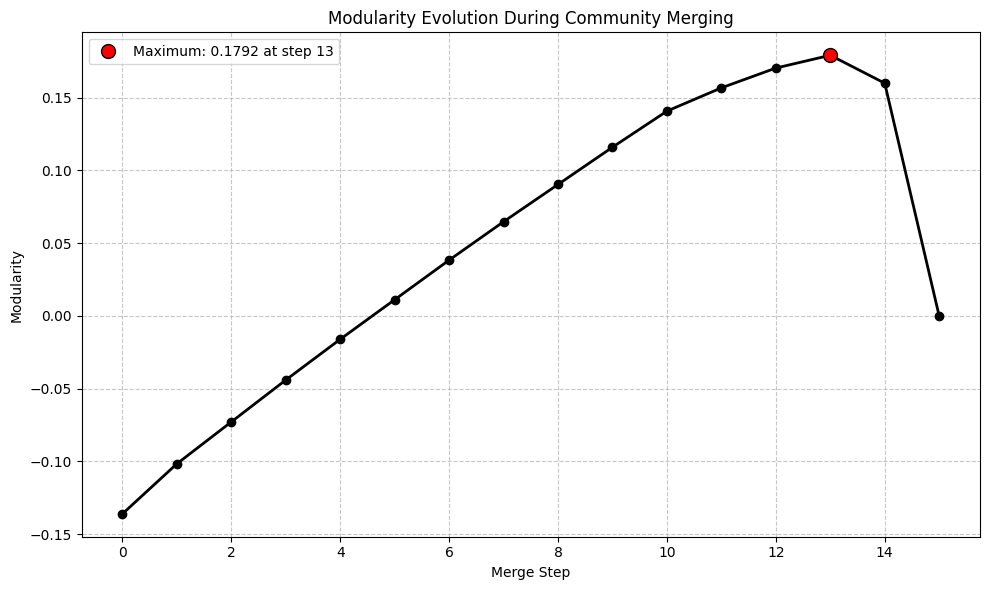

In [19]:
# Plot modularity evolution
plt.figure(figsize=(10, 6))

# Plot the modularity evolution in black
plt.plot(range(len(modularity_scores)), modularity_scores, 'o-', 
         linewidth=2, color='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Merge Step')
plt.ylabel('Modularity')
plt.title('Modularity Evolution During Community Merging')

# Mark the maximum modularity point
plt.plot(best_step, modularity_scores[best_step], 'o', ms=10, 
         color='red', markeredgecolor='black',
         label=f'Maximum: {modularity_scores[best_step]:.4f} at step {best_step}')
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

The Clauset-Newman-Moore greedy algorithm provides an efficient approach to community detection through modularity optimization. Key takeaways:

1. **Efficiency**: The algorithm's O(N log²N) time complexity makes it practical for medium-sized networks (thousands of nodes), significantly faster than the original Newman algorithm's O(N³) complexity.

2. **Hierarchical Structure**: The algorithm naturally produces a hierarchical organization of communities, allowing for multi-level community analysis.

3. **Quality**: For the Zachary Karate Club network, the algorithm produces communities that align well with the ground truth, as shown by the high ARI and NMI values.

4. **Resolution Limit**: Like all modularity-based methods, the algorithm may struggle to detect very small communities in large networks due to the "resolution limit" of modularity.

5. **Implementation Considerations**: While the concept is straightforward, efficient implementation requires careful data structure design:
   - Using max heaps to quickly find the best community pair to merge
   - Sparse matrix representations to efficiently store and update community connections
   - Efficiently updating modularity changes without recalculating from scratch

6. **Practical Applications**: The algorithm is well-suited for:
   - Social network analysis
   - Biological networks (protein-protein interaction networks)
   - Information networks (citation networks, web graphs)
   - Infrastructure networks (power grids, transportation networks)

The NetworkX implementation provides a convenient and optimized way to apply this algorithm to your own networks, with options for handling weighted and directed networks through parameters in the `greedy_modularity_communities()` function.